In [35]:

import numpy as np
import pandas as pd

import matplotlib.pylab as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers.core import Dense,Activation,Dropout
from keras.layers.recurrent import LSTM

import math

import statsmodels as sm
import statsmodels.api as smt

In [36]:
raw_data = pd.read_csv('Covid_19_train.csv')
raw_data.tail(10)

,Time,Daily_cases
195,2020-09-11,865.0
196,2020-09-12,1085.0
197,2020-09-13,788.0
198,2020-09-14,635.0
199,2020-09-15,1458.0
200,2020-09-16,1266.0
201,2020-09-17,1475.0
202,2020-09-18,1540.0
203,2020-09-19,1582.0
204,2020-09-20,1213.0


In [37]:
raw_data.info()
#no missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         205 non-null    object 
 1   Daily_cases  205 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


In [89]:
#using time as index
raw_data['Time']=pd.to_datetime(raw_data['Time'])
raw_timeindex=raw_data .set_index('Time', inplace=False)
raw_timeindex.head()

,Daily_cases
Time,
2020-02-29,1.0
2020-03-01,9.0
2020-03-02,3.0
2020-03-03,9.0
2020-03-04,16.0


In [185]:
#### divide the train set and test set(only for return dataset)

train = raw_timeindex[:len(raw_timeindex)-15]
train.info()
val = raw_timeindex[len(raw_timeindex)-15:]
val.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 190 entries, 2020-02-29 to 2020-09-05
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Daily_cases  190 non-null    float64
dtypes: float64(1)
memory usage: 3.0 KB


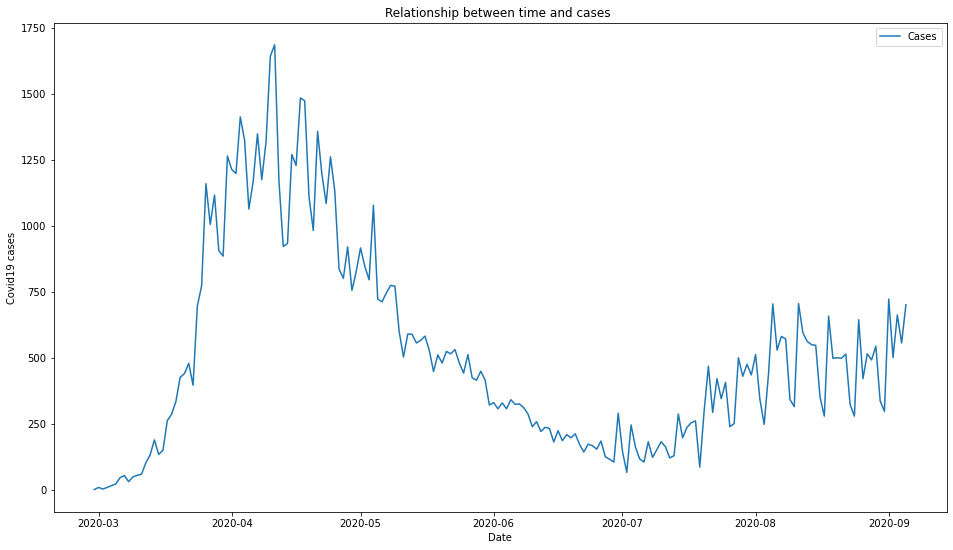

In [95]:
#plot
ts = train['Daily_cases']
plt.figure(figsize=(16,9)) 
plt.plot(ts,label='Cases')
plt.title('Relationship between time and cases ')  # Add title to the plot
plt.xlabel('Date')                                      # Add label to the x-axis
plt.ylabel('Covid19 cases')  
plt.legend()
#plt.savefig('')
plt.show()
# changing variance

In [96]:
## EDA 1)Using moving average to find trend 2)remove trend to get seasonal 3)find seasonal pattern 4)remove seansonal pattern 

In [97]:
## Decomposition

In [98]:
### Step 1 moving average to reveal trend component

Time
2020-02-29          NaN
2020-03-01          NaN
2020-03-02          NaN
2020-03-03    15.142857
2020-03-04    22.714286
Name: Daily_cases, dtype: float64


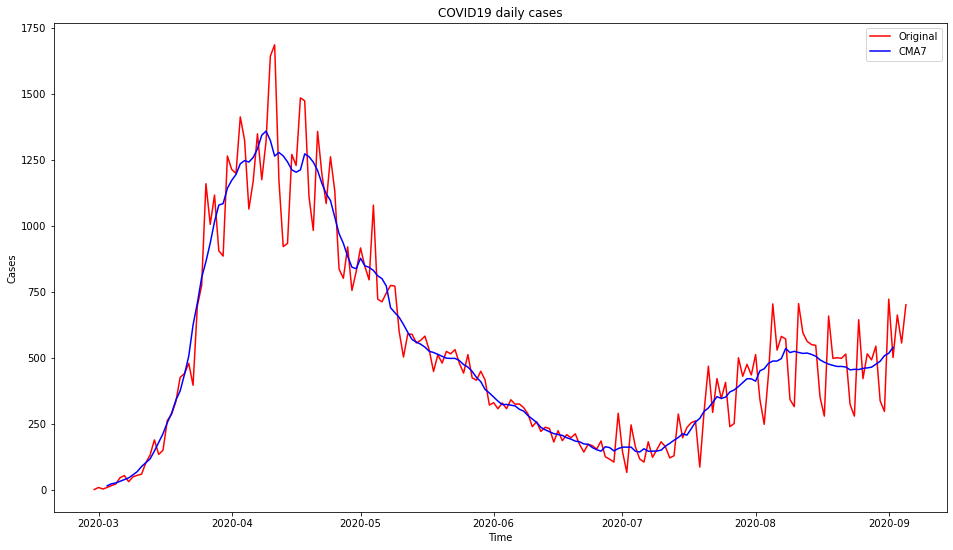

In [99]:
### Step 1 moving average
### 因为图中看起来一个月有4个左右的波动 大概seasonal pattern是7 days

# Apply CMA with m=7 to initially estimate the trend

trend = ts.rolling(7,center=True).mean()
#ts_MA9 = ts.rolling(9,center=True)
print(trend.head())
# Plot the estimated trend
plt.figure(figsize = (16,9))
plt.plot(ts, color='red',label='Original')
plt.plot(trend , color='blue',label='CMA7')
plt.title('COVID19 daily cases')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend()
#plt.savefig('3.CMA-4.png')
plt.show()


In [ ]:
### Step 2 remove trend to Estimating the Seasonal Component
#### two possible method

Time
2020-02-29         NaN
2020-03-01         NaN
2020-03-02         NaN
2020-03-03    0.594340
2020-03-04    0.704403
                ...   
2020-09-01    1.396518
2020-09-02    0.928761
2020-09-03         NaN
2020-09-04         NaN
2020-09-05         NaN
Name: Daily_cases, Length: 190, dtype: float64


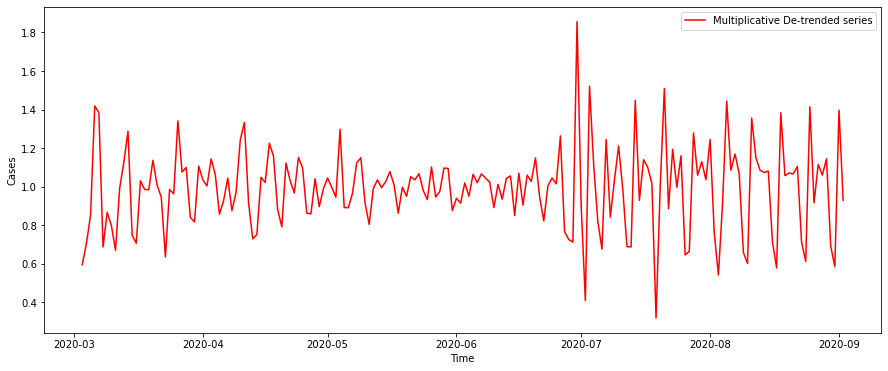

In [100]:
#mulitplicative 
ts_res_mul = ts/trend
print(ts_res_mul)


# Plot the de-trended series
plt.figure(figsize = (15,6))
plt.plot(ts_res_mul,'r-',label="Multiplicative De-trended series")
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend()
plt.show()



Time
2020-02-29           NaN
2020-03-01           NaN
2020-03-02           NaN
2020-03-03     -6.142857
2020-03-04     -6.714286
                 ...    
2020-09-01    205.000000
2020-09-02    -38.428571
2020-09-03           NaN
2020-09-04           NaN
2020-09-05           NaN
Name: Daily_cases, Length: 190, dtype: float64


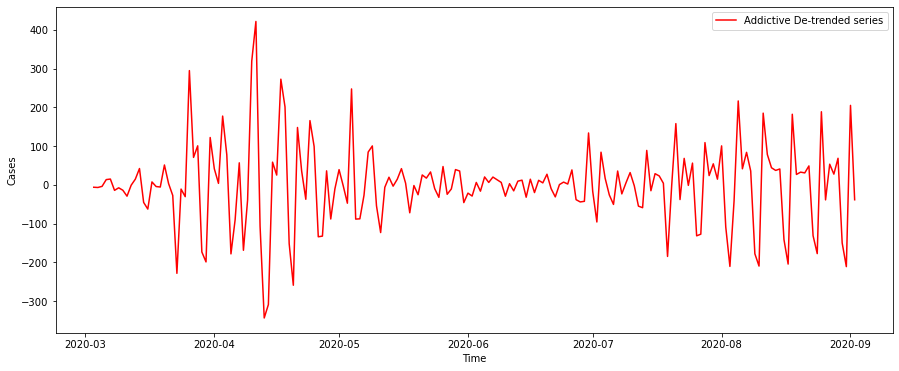

In [136]:
ts_res_add = ts-trend
print(ts_res_add)

# Plot the de-trended series
plt.figure(figsize = (15,6))
plt.plot(ts_res_add,'r-',label="Addictive De-trended series")
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend()
plt.show()


In [132]:
### Step 3 Estimate the seasonal component and normalized seasonal index  𝑆⎯⎯⎯⎯𝑡 . Obtain the seasonal adjusted series.
### 两个模型看起来差不太多 补课班偏向于add 所以后面先用add做一下

In [166]:
#ts1=ts_res_add.to_numpy()
#ts1

In [190]:
# Reshape the de-trended series to a table. 
#这部分处理可以考虑用tonumpy +np nanmean
ts_res_zero = np.nan_to_num(ts_res_mul)
# A column contains data in a 7 days.
# For example, column 1 contains number of cases in Monday of 1 weeks
week_S = np.reshape(ts_res_zero[1:] ,(-1,7))
print(week_S)
# Calculate column averages (Average number of cases in 7 days of 1 weeks)
week_avg = np.mean(week_S[1:6,:], axis=0)
#monthly_avg = np.nanmean(monthly_S, axis=1)
week_avg

[[0.         0.         0.59433962 0.70440252 0.85082873 1.4185022
  1.38461538]
 [0.68670886 0.86616162 0.79875519 0.66936791 0.99166667 1.12545676
  1.28696498]
 [0.74741036 0.7061197  1.02975856 0.98523622 0.98359276 1.13686618
  1.00752372]
 [0.94610609 0.63447013 0.98464026 0.9621266  1.34099174 1.07585258
  1.09919797]
 [0.83940639 0.81663591 1.1069686  1.03536154 1.00323005 1.14371673
  1.06211322]
 [0.85656728 0.92824705 1.04403629 0.87434833 0.97117913 1.2412527
  1.33352176]
 [0.91678783 0.72847458 0.75138058 1.04834906 1.02102387 1.225
  1.15801887]
 [0.8799547  0.79138844 1.12241522 1.0307806  0.96687054 1.15129777
  1.09598893]
 [0.86198262 0.85838947 1.04089219 0.89561091 0.98788396 1.04481017
  0.99713757]
 [0.94386024 1.29790162 0.89104372 0.89047704 0.96556193 1.12266888
  1.14976566]
 [0.91730475 0.80351438 0.98945855 1.03462986 0.99412516 1.02642487
  1.07749273]
 [1.00844227 0.86153846 0.99665645 0.94968909 1.0513041  1.03502728
  1.06687715]
 [0.98016336 0.9322085 

array([0.8152398 , 0.79032688, 0.99283178, 0.90528812, 1.05813207,
       1.14462899, 1.15786433])

In [191]:
# Normalize the seasonal index
#Then we should normalize our data in order to obtain a unique solution. 
#For additive decomposition, we should make the mean of seasonal index equal to zero. Therefore, we should take the mean of the seasonal index out of the original seasonal index.
mean_week = week_avg.mean()
week_normal= week_avg / mean_week
print(week_normal.sum())

7.0


Next, we need to calculate the seasonal adjusted data. In order to calculate the seasonal adjusted data, we need to have original data  𝑌𝑡  minus by the normalized seasonal index  𝑆⎯⎯⎯⎯𝑡 :

𝑇𝑡+𝑅𝑡ˆ=𝑌𝑡−𝑆⎯⎯⎯⎯𝑡
 
Since the size of original data  𝑌𝑡  and normalized seasonal index  𝑆⎯⎯⎯⎯𝑡  does not match, we need to repeat the  𝑆⎯⎯⎯⎯𝑡  over 12 years and subtract the seasonal average from the original data:

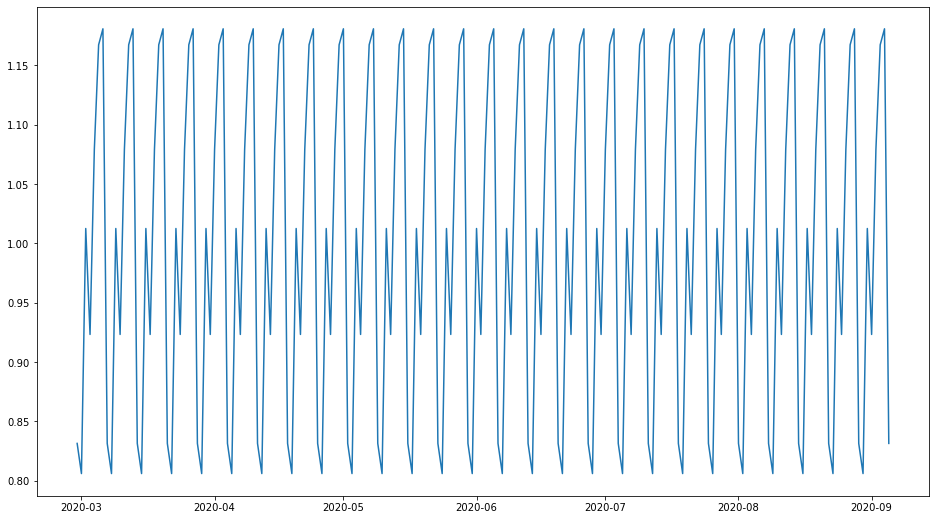

In [202]:
# Replicate the normalized seasonal index array 12 times
tiled_avg = np.tile(week_normal,28)[:-6]

plt.figure(figsize = (16,9))
plt.plot(train.index,tiled_avg)
plt.show()


In [193]:
### Step 4: Update the trend-cycle component

In [194]:
# Subtract the seasonal average from the original data to obtain the seasonal adjusted data
trend_deseason = ts /tiled_avg

In [195]:
trend_deseason 

Time
2020-02-29      1.202856
2020-03-01     11.166954
2020-03-02      2.963088
2020-03-03      9.748879
2020-03-04     14.827881
                 ...    
2020-09-01    782.076703
2020-09-02    464.298010
2020-09-03    567.142537
2020-09-04    470.886337
2020-09-05    843.201983
Name: Daily_cases, Length: 190, dtype: float64

In [196]:
#use a moving average method to regenerate the trend-cycle. 
T_final = seasonally_adjusted.rolling(7, center=True).mean()

In [197]:
T_final

Time
2020-02-29           NaN
2020-03-01           NaN
2020-03-02           NaN
2020-03-03     15.142857
2020-03-04     22.714286
                 ...    
2020-09-01    517.000000
2020-09-02    539.428571
2020-09-03           NaN
2020-09-04           NaN
2020-09-05           NaN
Name: Daily_cases, Length: 190, dtype: float64

,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,...,2020-08-28 00:00:00,2020-08-29 00:00:00,2020-08-30 00:00:00,2020-08-31 00:00:00,2020-09-01 00:00:00,2020-09-02 00:00:00,2020-09-03 00:00:00,2020-09-04 00:00:00,2020-09-05 00:00:00,Daily_cases
Time,,,,,,,,,,,,,,,,,,,,,
2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
